In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sbi
#import tarp FIXME todo
from scipy.stats import norm
opj = os.path.join

In [2]:
# INPUT
idir = '/mnt/home/abayer/cca_project/output/run36'
quantiles = np.arange(0.05, 1.05, 0.05)            # which quantiles to plot
param_names = ['param %s'%i for i in range(ncols)]   # FIXME replace


In [3]:
# load posterior
with open(opj(idir, 'posterior.pkl'), 'rb') as f:
    posterior = pickle.load(f)

2025-05-20 13:43:48.766352: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 13:43:49.247387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# load prior draws and generatd data
param_draws = np.load(opj(idir, 'param_draws_test.npy'))
data_draws = np.load(opj(idir, 'data_draws_test.npy'))

In [29]:
def compute_coverage_mean_std(posterior, param_draws, data_draws, quantiles=[.95]):
    """
    Generate a coverage plot based on posterior samples from SBI, where true parameters are part of the dataloader.

    Parameters:
    - posterior: SBI posterior object
    - param_draws: [num_draws, nparams]
    - data_draws: [num_draws, ndimdata]  simulated data from the simulator
    - quantiles: Desired coverage levels (default [.95]).
    
    Returns:
    - coverage (shape = nquants, nparams)
    - means    (shape = num_draws, nparams)
    - stds     (shape = num_draws, nparams)
    """
    num_draws = param_draws.shape[0]  # number of prior draws
    num_samples = 1000                # number of posterior samples to draw
    
    # To track the coverage for each parameter dimension
    total_coverage = []
    means = []
    stds = []
    
    for i in range(num_draws):
        # Draw posterior samples (num_samples could be adjusted)
        posterior_samples = posterior.sample((num_samples,), x=data_draws[i], show_progress_bars=False).numpy().T
        true_params = param_draws[i]

        # Calculate coverage for each parameter in the true_params
        coverage_per_param_quantile = np.zeros((len(quantiles), true_params.shape[0]))
        for qi,quantile in enumerate(quantiles):
            coverage_per_param = np.zeros(len(true_params))
            for pi in range(len(true_params)):  # Iterate over the parameter dimensions
                # Calculate the quantile bounds for the posterior samples of the i-th parameter
                lower_bound = np.quantile(posterior_samples[pi], (1 - quantile) / 2)
                upper_bound = np.quantile(posterior_samples[pi], 1 - (1 - quantile) / 2)
                
                # Check if the true parameter is within the bounds
                coverage_per_param[pi] = ((true_params[pi] >= lower_bound) &     # note the mean here is if i do batching, but posterior doesn't like matching, so this does nothing now
                                        (true_params[pi] <= upper_bound))
            
            coverage_per_param_quantile[qi] = coverage_per_param
        
        total_coverage.append(coverage_per_param_quantile)
        means.append(np.mean(posterior_samples, axis=-1))
        stds.append(np.std(posterior_samples, axis=-1))

    coverage = np.mean(total_coverage, axis=0)   # taking the mean over all sims. This will have shape = num_params
    return coverage, np.array(means), np.array(stds)

In [30]:
# compute coverage, means, stds
coverages, means, stds = compute_coverage_mean_std(posterior, param_draws, data_draws, quantiles=quantiles)

In [31]:
coverages.shape, means.shape, stds.shape

((20, 7), (864, 7), (864, 7))

Text(0, 0.5, 'prob')

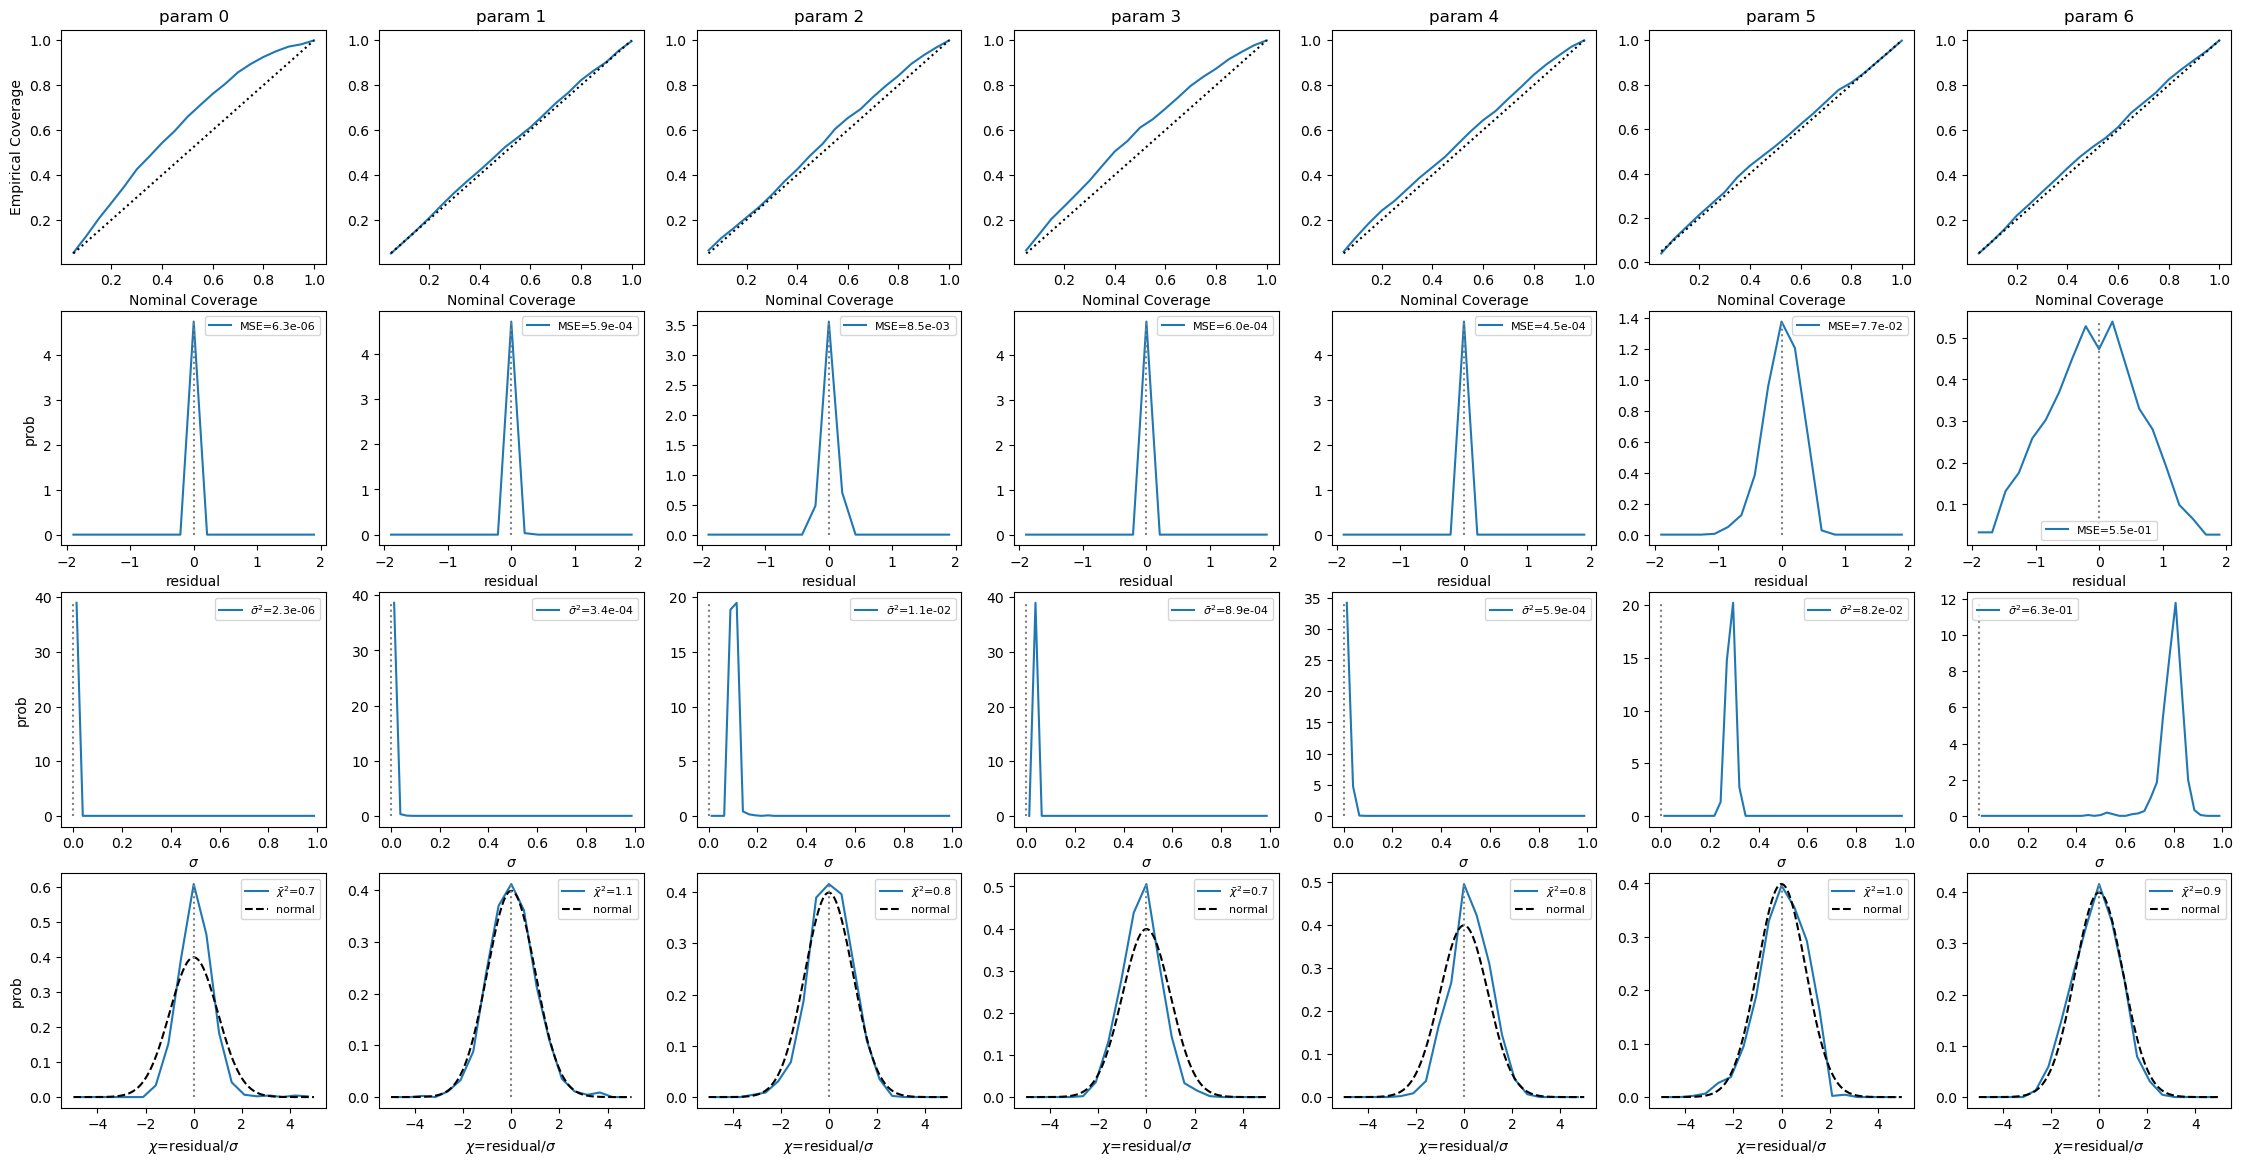

In [40]:
# plot all coverage information. may want to change bin_edges_params for each panel below
ncols = param_draws.shape[1]
fig, ax = plt.subplots(4, ncols, figsize=(4*ncols,14), squeeze=False)
true_params = param_draws.T

# coverage plot
for pi in range(ncols):
    ax[0,pi].set_title(param_names[pi])
    ax[0,pi].plot(quantiles, coverages[:,pi])
    ax[0,pi].plot(quantiles, quantiles, color='k', linestyle=':')
    ax[0,pi].set_xlabel('Nominal Coverage')

# residual plot
bin_edges_params = [np.linspace(-2, 2, 20)]*ncols
for pi in range(ncols):  # coverage makes no sense except fo iso and ap
    bin_edges = bin_edges_params[pi]
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    res = means[:,pi] - true_params[pi]
    MSE = np.mean(res**2)
    h, _ = np.histogram(res, bins=bin_edges, density=1)
    ax[1,pi].plot(bin_centers, h, label='MSE=%.1e'%MSE)
    ax[1,pi].set_xlabel('residual')
    ax[1,pi].legend(fontsize=8)
    ax[1,pi].vlines(0,h.min(),h.max(), color='gray', linestyle=':')

# var plot
bin_edges_params = [np.linspace(0, 1, 40)]*ncols
for pi in range(ncols):  # coverage makes no sense except fo iso and ap
    bin_edges = bin_edges_params[pi]
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    sig = stds[:,pi]
    avgsig2 = np.mean(sig**2)
    h, _ = np.histogram(sig, bins=bin_edges, density=1)
    ax[2,pi].plot(bin_centers, h, label=r'$\bar{\sigma}^2$=%.1e'%avgsig2)
    ax[2,pi].set_xlabel(r'$\sigma$')
    ax[2,pi].legend(fontsize=8)
    ax[2,pi].vlines(0,h.min(),h.max(), color='gray', linestyle=':')

# chi plot
bin_edges_params = [np.linspace(-5, 5, 20)]*ncols
for pi in range(ncols):  # coverage makes no sense except fo iso and ap
    bin_edges = bin_edges_params[pi]
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    res = means[:,pi] - true_params[pi]
    sig = stds[:,pi]
    chi = res/sig
    avgchisq = np.mean(chi**2)
    h, _ = np.histogram(chi, bins=bin_edges, density=1)
    ax[3,pi].plot(bin_centers, h, label=r'$\bar{\chi}^2$=%.1f'%avgchisq)
    _z = np.linspace(-5,5,1000)
    ax[3,pi].plot(_z, norm.pdf(_z), label='normal', color='k', linestyle='--')
    ax[3,pi].set_xlabel(r'$\chi$=residual/$\sigma$')
    ax[3,pi].legend(fontsize=8)
    ax[3,pi].vlines(0,h.min(),h.max(), color='gray', linestyle=':')


ax[0,0].set_ylabel('Empirical Coverage')
ax[1,0].set_ylabel('prob')
ax[2,0].set_ylabel('prob')
ax[3,0].set_ylabel('prob')

#fig.savefig(opj(plot_dir, 'coverage.png'))